In [1]:
import os
from io import open
from conllu import parse
import networkx as nx
from Measures import Compute_measures
import matplotlib.pyplot as plt
import numpy as np

DL = []
IC=[]

directory = "./SUD"  # Directory containing the UD scheme tree files in CONLLU format
ud_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('train.conllu'):
            fullpath = os.path.join(root, file)
            ud_files.append(fullpath)  # Creates a list of paths of all files (file of each language) from the directory

for i in ud_files:  # Reads file of each language one by one

    data_file = open(str(i), 'r', encoding='utf-8').read()
    sentences = parse(data_file)  # parses the CONLLU format

    for sentence in sentences[0:]:
        tree = nx.DiGraph()  # An empty directed graph (i.e., edges are uni-directional)
        ROOT = 0
        tree.add_node(ROOT)
        for nodeinfo in sentence[0:]:  # retrieves information of each node from dependency tree in UD format
            entry = list(nodeinfo.items())
            if entry[7][1] != 'punct':
                tree.add_node(entry[0][1], form=entry[1][1], lemma=entry[2][1], upostag=entry[3][1],
                              xpostag=entry[4][1], feats=entry[5][1], head=entry[6][1], deprel=entry[7][1],
                              deps=entry[8][1], misc=entry[9][1])  # adds node to the directed graph
        
        nodes=tree.nodes
        get = Compute_measures(tree)

        for nodex in nodes:
            if nodex != 0 and tree.has_node(nodes[nodex]['head']):                       # to handle disjoint trees               
                tree.add_edge(nodes[nodex]['head'], nodex, drel=nodes[nodex]['deprel'])  # adds edges as relation between nodes
        
        for edgey in tree.edges:
            if edgey[0] != 0:
                dep_distance = get.dependency_distance(edgey)
                ic = get.dependency_depth(edgey)
                DL.append(dep_distance)
                IC.append(ic)

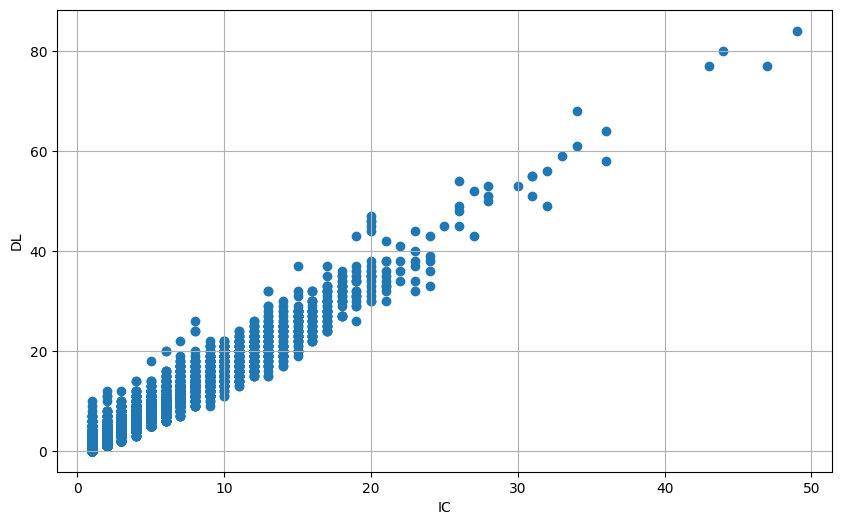

In [2]:
plt.figure(1,figsize=(10, 6))
plt.scatter(IC,DL)
plt.xlabel('IC')
plt.ylabel('DL')
plt.grid()
plt.show()

In [3]:
import statistics
from collections import defaultdict

DL_IC = defaultdict(list)

for dl, ic in zip(DL, IC):
    DL_IC[dl].append(ic)

for dl, ic in DL_IC.items():
    DL_IC[dl] = statistics.mean(ic) if ic else None

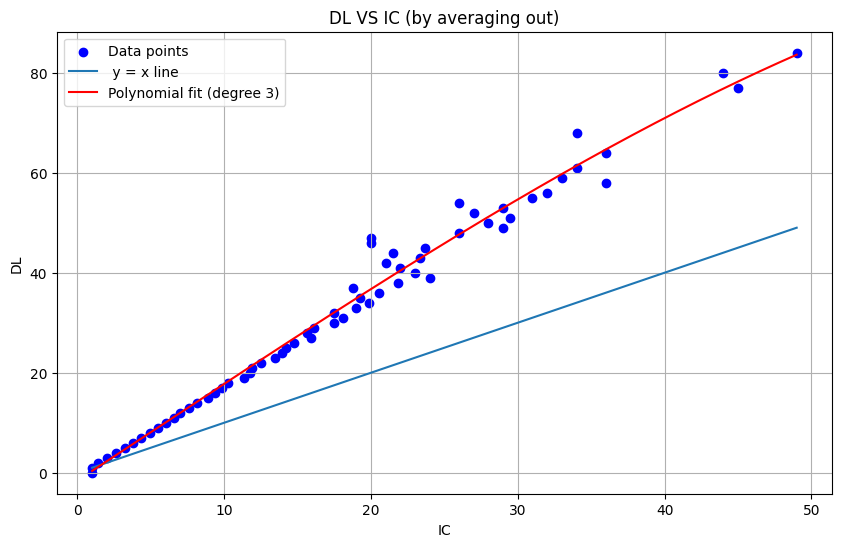

In [4]:
IC_avg=list(DL_IC.values())
DL_avg=list(DL_IC.keys())

x=np.linspace(min(IC_avg),max(IC_avg),1000)

degree = 3
coefficients = np.polyfit(IC_avg, DL_avg, degree)

IC_fit=np.linspace(min(IC_avg),max(IC_avg),1000)
DL_fit = np.polyval(coefficients, IC_fit)

plt.figure(2,figsize=(10, 6))
plt.scatter(IC_avg, DL_avg, color='blue', label='Data points')
plt.plot(x,x,label=' y = x line')
plt.plot(IC_fit, DL_fit, color='red', label=f'Polynomial fit (degree {degree})')
plt.xlabel('IC')
plt.ylabel('DL')
plt.title('DL VS IC (by averaging out)')
plt.legend()
plt.grid()
plt.show()